In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


In [2]:
df = pd.read_csv("data_iris.csv") 

In [3]:
df.head()

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),species
0,5.1,3.5,1.4,0.2,setosa
1,4.9,3.0,1.4,0.2,setosa
2,4.7,3.2,1.3,0.2,setosa
3,4.6,3.1,1.5,0.2,setosa
4,5.0,3.6,1.4,0.2,setosa


In [3]:
#df['target'] = le.fit_transform(df['species'] )

In [5]:
# Séparation X / y
X = df.drop("species", axis=1)
y = df["species"]

In [6]:

from sklearn.preprocessing import LabelEncoder
# Encodage de la cible
le = LabelEncoder()
y_encoded = le.fit_transform(y)
class_names = le.classes_

In [8]:
class_names

array(['setosa', 'versicolor', 'virginica'], dtype=object)

In [9]:
# Transformation en dictionnaire
label_names = {i: name for i, name in enumerate(class_names)}

print(label_names)

{0: 'setosa', 1: 'versicolor', 2: 'virginica'}


In [8]:
from sklearn.model_selection import train_test_split
# Séparation Train/Test
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.3, random_state=42, stratify=y_encoded)

In [9]:
from sklearn.preprocessing import StandardScaler
# Standardisation
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [10]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
# Modèles et grilles de paramètres
models = {
    'LogReg': LogisticRegression(max_iter=1000),
    'RandomForest': RandomForestClassifier(random_state=42),
    'SVM': SVC(probability=True)
}

In [11]:
from sklearn.metrics import classification_report
#  Évaluation
for name, model in models.items():
    model.fit(X_train_scaled,y_train)
    y_pred = model.predict(X_test_scaled)
    print(f"\n {name} - Classification Report :\n")
    print(classification_report(y_test, y_pred, target_names=class_names))


 LogReg - Classification Report :

              precision    recall  f1-score   support

      setosa       1.00      1.00      1.00        15
  versicolor       0.82      0.93      0.87        15
   virginica       0.92      0.80      0.86        15

    accuracy                           0.91        45
   macro avg       0.92      0.91      0.91        45
weighted avg       0.92      0.91      0.91        45


 RandomForest - Classification Report :

              precision    recall  f1-score   support

      setosa       1.00      1.00      1.00        15
  versicolor       0.78      0.93      0.85        15
   virginica       0.92      0.73      0.81        15

    accuracy                           0.89        45
   macro avg       0.90      0.89      0.89        45
weighted avg       0.90      0.89      0.89        45


 SVM - Classification Report :

              precision    recall  f1-score   support

      setosa       1.00      1.00      1.00        15
  versicolor      

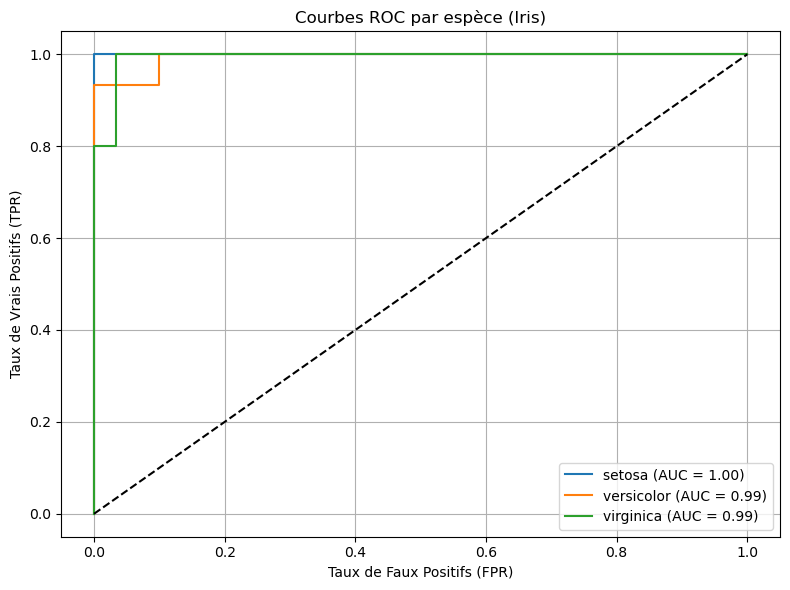

In [12]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize

# Binarisation des classes pour ROC multiclasse
y_test_bin = label_binarize(y_test, classes=np.unique(y_test))
n_classes = y_test_bin.shape[1]


# Prédictions de probabilités
y_prob = model.predict_proba(X_test_scaled) 

# Initialisation des courbes ROC par classe
fpr = dict()
tpr = dict()
roc_auc = dict()

# Courbe ROC pour chaque classe (1 contre tous)
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_prob[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Calcul de la courbe ROC macro (moyenne)
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))
mean_tpr = np.zeros_like(all_fpr)

for i in range(n_classes):
    mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])
mean_tpr /= n_classes
roc_auc_macro = auc(all_fpr, mean_tpr)

# Tracé
fig, ax1 = plt.subplots(figsize=(8, 6))

# Tracer chaque courbe ROC
for i in range(n_classes):
    ax1.plot(fpr[i], tpr[i],
             label=f"{label_names.get(i, f'Classe {i}')} (AUC = {roc_auc[i]:.2f})")



# Courbe de base (modèle aléatoire)
ax1.plot([0, 1], [0, 1], 'k--')

# Mise en forme
ax1.set_xlabel('Taux de Faux Positifs (FPR)')
ax1.set_ylabel('Taux de Vrais Positifs (TPR)')
ax1.set_title('Courbes ROC par espèce (Iris)')
ax1.legend(loc='lower right')
ax1.grid(True)
plt.tight_layout()
plt.show()



In [13]:
from sklearn.feature_selection import SelectKBest, f_classif
# Sélection de caractéristiques
selector = SelectKBest(score_func=f_classif, k=3)
X_train_sel = selector.fit_transform(X_train_scaled, y_train)
X_test_sel = selector.transform(X_test_scaled)

In [14]:
# Pour récupérer les noms des colonnes sélectionnées
mask = selector.get_support()  # tableau booléen indiquant les colonnes sélectionnées
selected_features = X.columns[mask]

print("Colonnes sélectionnées :", list(selected_features))

Colonnes sélectionnées : ['sepal length (cm)', 'petal length (cm)', 'petal width (cm)']


In [15]:
# Modèles et grilles de paramètres
models = {
    'LogReg': LogisticRegression(max_iter=1000),
    'RandomForest': RandomForestClassifier(random_state=42),
    'SVM': SVC(probability=True)
}

param_grids = {
    'LogReg': {
        'C': [0.01, 0.1, 1, 10],
        'penalty': ['l2'],
        'solver': ['liblinear']
    },
    'RandomForest': {
        'n_estimators': [50, 100],
        'max_depth': [None, 5, 10]
    },
    'SVM': {
        'C': [0.1, 1, 10],
        'kernel': ['linear', 'rbf']
    }
}




In [16]:
from sklearn.model_selection import GridSearchCV
# Entraînement avec GridSearchCV
best_models = {}

for name, model in models.items():
    print(f"\n Recherche pour {name}")
    grid = GridSearchCV(model, param_grids[name], cv=5, scoring='accuracy', n_jobs=-1)
    grid.fit(X_train_sel, y_train)
    best_models[name] = grid.best_estimator_
    print("Meilleurs paramètres :", grid.best_params_)

#  Évaluation
for name, model in best_models.items():
    y_pred = model.predict(X_test_sel)
    print(f"\n {name} - Classification Report :\n")
    print(classification_report(y_test, y_pred, target_names=class_names))




 Recherche pour LogReg
Meilleurs paramètres : {'C': 10, 'penalty': 'l2', 'solver': 'liblinear'}

 Recherche pour RandomForest
Meilleurs paramètres : {'max_depth': 5, 'n_estimators': 50}

 Recherche pour SVM
Meilleurs paramètres : {'C': 0.1, 'kernel': 'linear'}

 LogReg - Classification Report :

              precision    recall  f1-score   support

      setosa       1.00      1.00      1.00        15
  versicolor       0.82      0.93      0.87        15
   virginica       0.92      0.80      0.86        15

    accuracy                           0.91        45
   macro avg       0.92      0.91      0.91        45
weighted avg       0.92      0.91      0.91        45


 RandomForest - Classification Report :

              precision    recall  f1-score   support

      setosa       1.00      1.00      1.00        15
  versicolor       0.78      0.93      0.85        15
   virginica       0.92      0.73      0.81        15

    accuracy                           0.89        45
   macr